In [1]:
import numpy as np
import pandas as pd
from darts import TimeSeries,concatenate
from darts.models import XGBModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
from captum.attr import IntegratedGradients, NoiseTunnel
import json
import matplotlib.pyplot as plt
from darts.explainability.shap_explainer import ShapExplainer

In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [3]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
        "future":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [8]:
# Como sei que o melhor modelo vai ser no fold 2, vou dar parar nele
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 16)]
    
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = XGBModel(
        model_name=f"model_{fold+1}",
        lags=target_lags_list,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        add_encoders=encoders,
        n_estimators=500,
        max_depth=8,
        learning_rate=0.17026371737320856,
        min_child_weight=1,
        subsample=0.7,
        colsample_bytree=0.6,
        gamma=0.0,
        reg_alpha=1.0130200568549804e-05,
        reg_lambda=0.2846100405536689
    )

    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
    )
    

    forecasts = model.historical_forecasts(
        train_scaled,
        forecast_horizon=1,
        start=0.8,
        stride=1,
        retrain=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled
    
    # Eu sei que o fold 2 é melhor
    if fold == 1:
        break
print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.34729
[1]	validation_0-rmse:0.31323


/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:14:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "model_name", "pl_trainer_kwargs" } are not used.



[2]	validation_0-rmse:0.28819
[3]	validation_0-rmse:0.26779
[4]	validation_0-rmse:0.25140
[5]	validation_0-rmse:0.23845
[6]	validation_0-rmse:0.22906
[7]	validation_0-rmse:0.22119
[8]	validation_0-rmse:0.21540
[9]	validation_0-rmse:0.21024
[10]	validation_0-rmse:0.20706
[11]	validation_0-rmse:0.20403
[12]	validation_0-rmse:0.20165
[13]	validation_0-rmse:0.19992
[14]	validation_0-rmse:0.19820
[15]	validation_0-rmse:0.19704
[16]	validation_0-rmse:0.19616
[17]	validation_0-rmse:0.19525
[18]	validation_0-rmse:0.19461
[19]	validation_0-rmse:0.19412
[20]	validation_0-rmse:0.19352
[21]	validation_0-rmse:0.19327
[22]	validation_0-rmse:0.19294
[23]	validation_0-rmse:0.19277
[24]	validation_0-rmse:0.19248
[25]	validation_0-rmse:0.19223
[26]	validation_0-rmse:0.19207
[27]	validation_0-rmse:0.19199
[28]	validation_0-rmse:0.19195
[29]	validation_0-rmse:0.19177
[30]	validation_0-rmse:0.19178
[31]	validation_0-rmse:0.19172
[32]	validation_0-rmse:0.19179
[33]	validation_0-rmse:0.19165
[34]	validation_

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:20.37458
[1]	validation_0-rmse:20.34949


/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:14:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "model_name", "pl_trainer_kwargs" } are not used.



[2]	validation_0-rmse:20.33500
[3]	validation_0-rmse:20.32321
[4]	validation_0-rmse:20.30854
[5]	validation_0-rmse:20.29684
[6]	validation_0-rmse:20.28674
[7]	validation_0-rmse:20.28076
[8]	validation_0-rmse:20.27371
[9]	validation_0-rmse:20.27073
[10]	validation_0-rmse:20.26586
[11]	validation_0-rmse:20.26183
[12]	validation_0-rmse:20.26033
[13]	validation_0-rmse:20.25894
[14]	validation_0-rmse:20.25657
[15]	validation_0-rmse:20.25584
[16]	validation_0-rmse:20.25479
[17]	validation_0-rmse:20.25345
[18]	validation_0-rmse:20.25332
[19]	validation_0-rmse:20.25220
[20]	validation_0-rmse:20.25141
[21]	validation_0-rmse:20.25106
[22]	validation_0-rmse:20.25100
[23]	validation_0-rmse:20.25045
[24]	validation_0-rmse:20.25034
[25]	validation_0-rmse:20.24995
[26]	validation_0-rmse:20.24974
[27]	validation_0-rmse:20.24958
[28]	validation_0-rmse:20.24950
[29]	validation_0-rmse:20.24947
[30]	validation_0-rmse:20.24945
[31]	validation_0-rmse:20.24936
[32]	validation_0-rmse:20.24924
[33]	validation_

In [9]:
s = scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
forecasts_t = scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


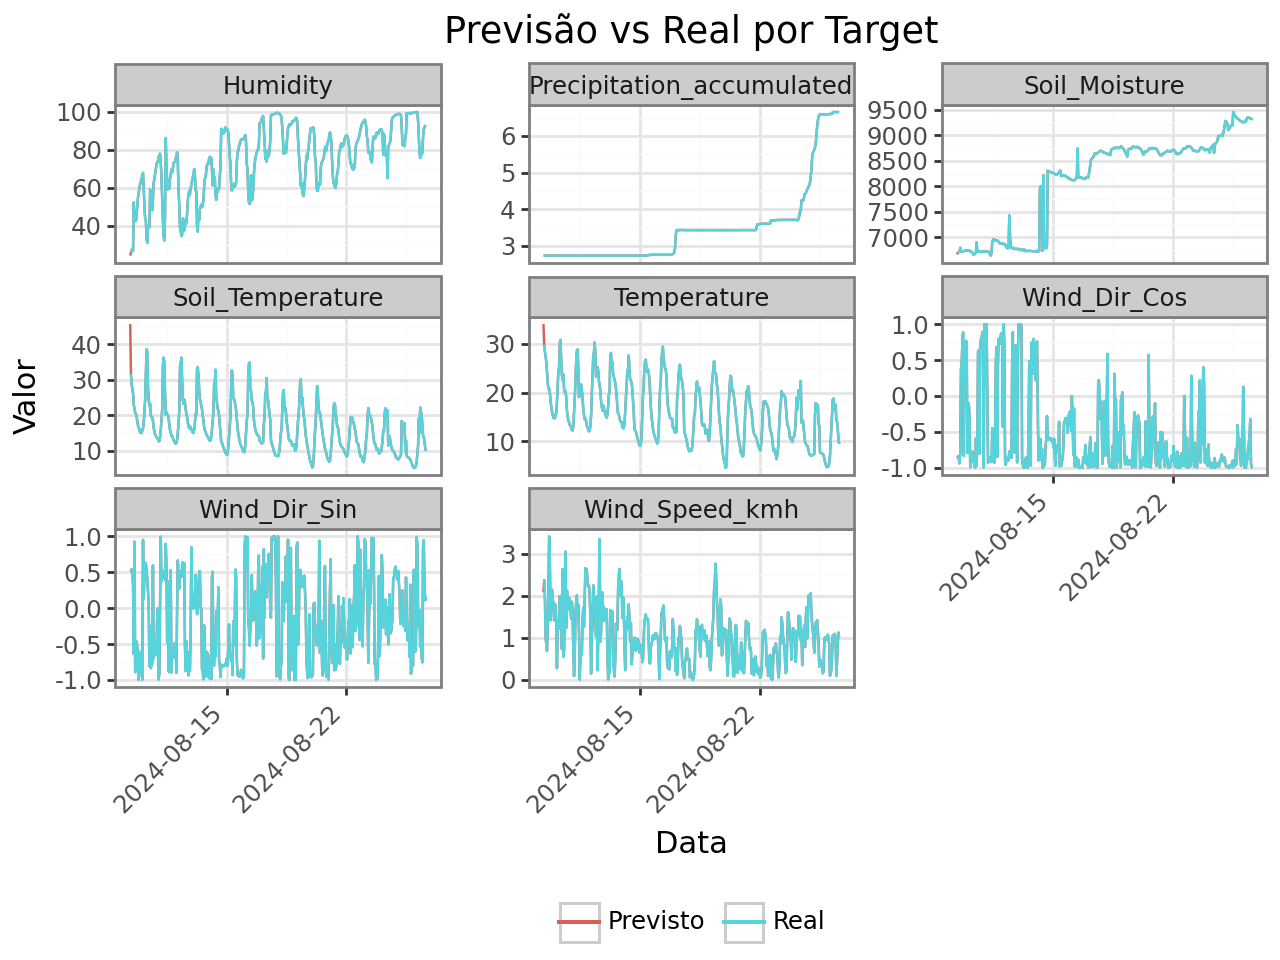

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [10]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [11]:
pred = model.predict(
    n=24,
    verbose=True
)

pred_t = best_scaler.inverse_transform(pred)
pred_df = pred_t.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

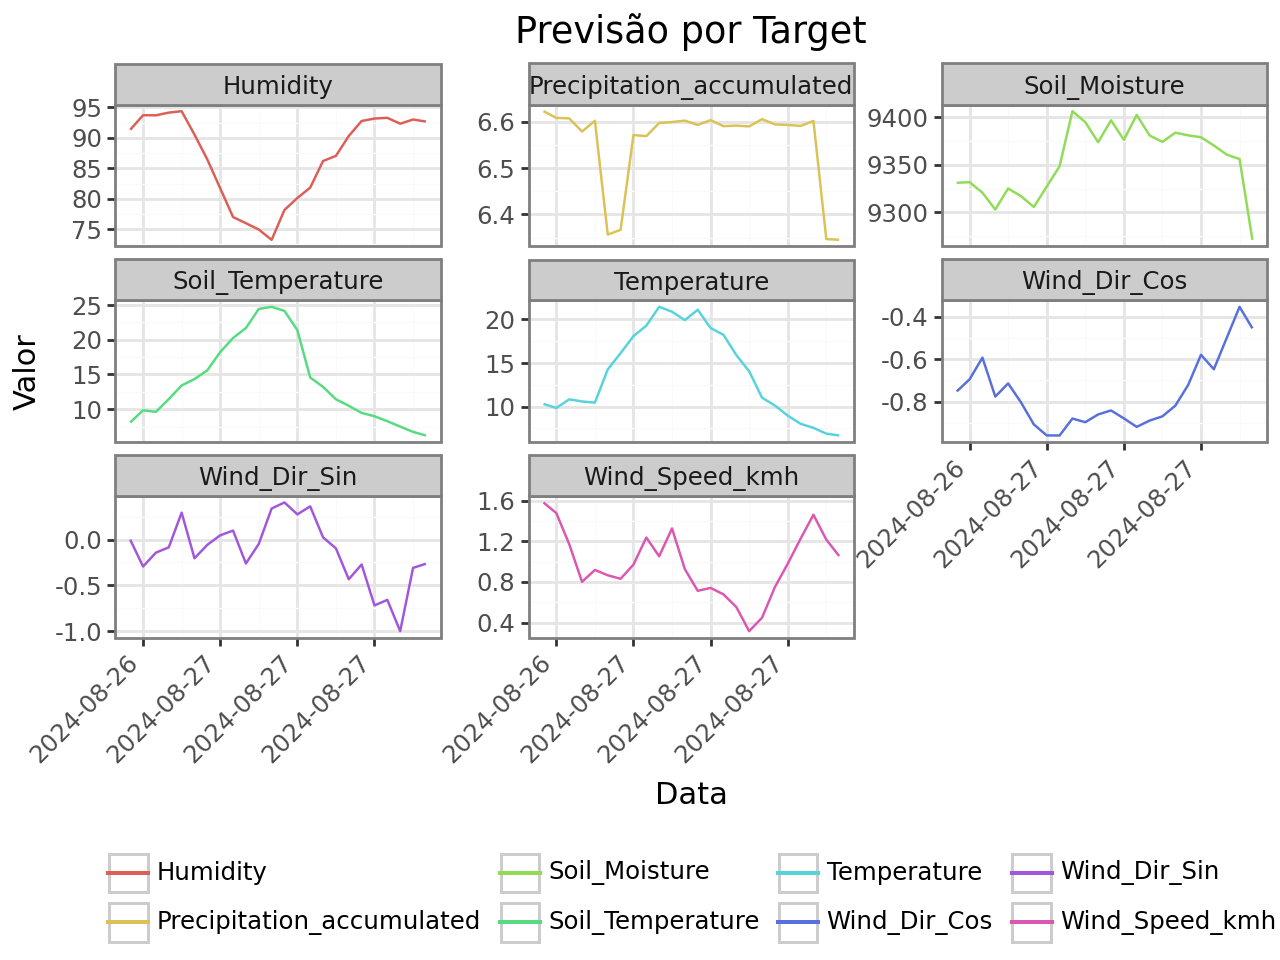

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [12]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [15]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

In [10]:
shap_explain = ShapExplainer(model)
results = shap_explain.explain()

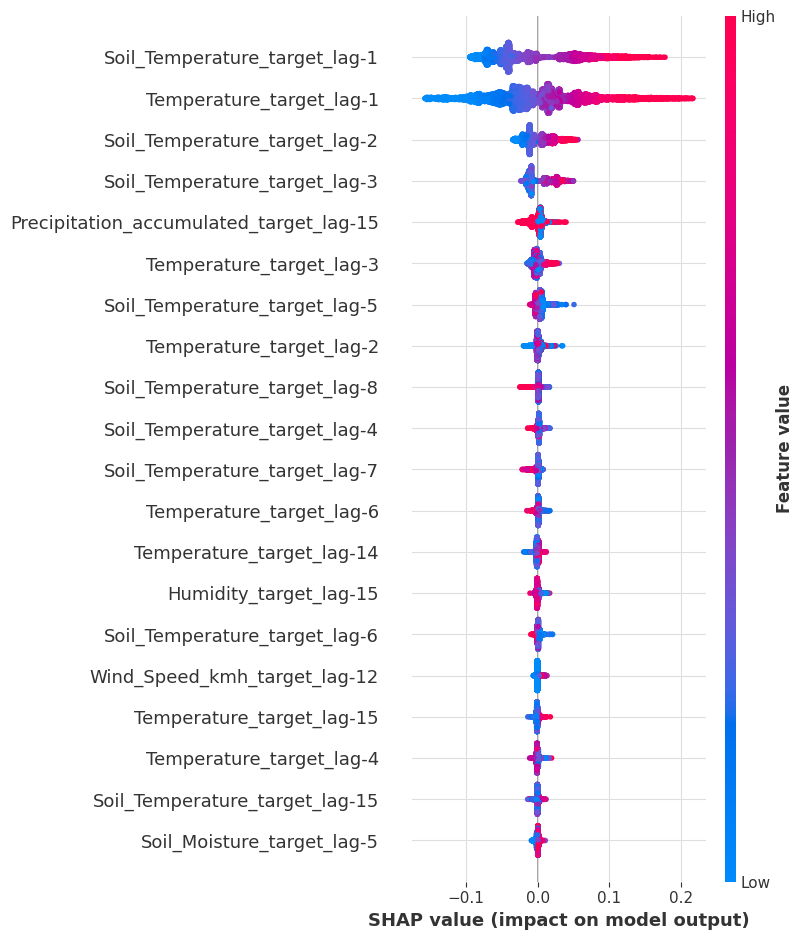

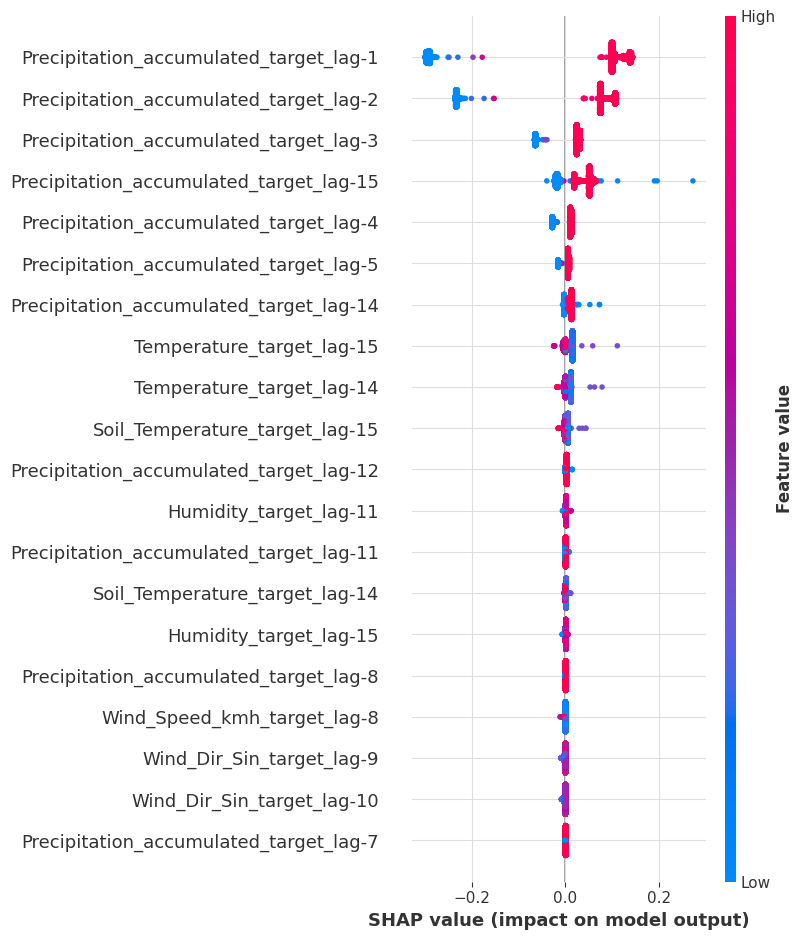

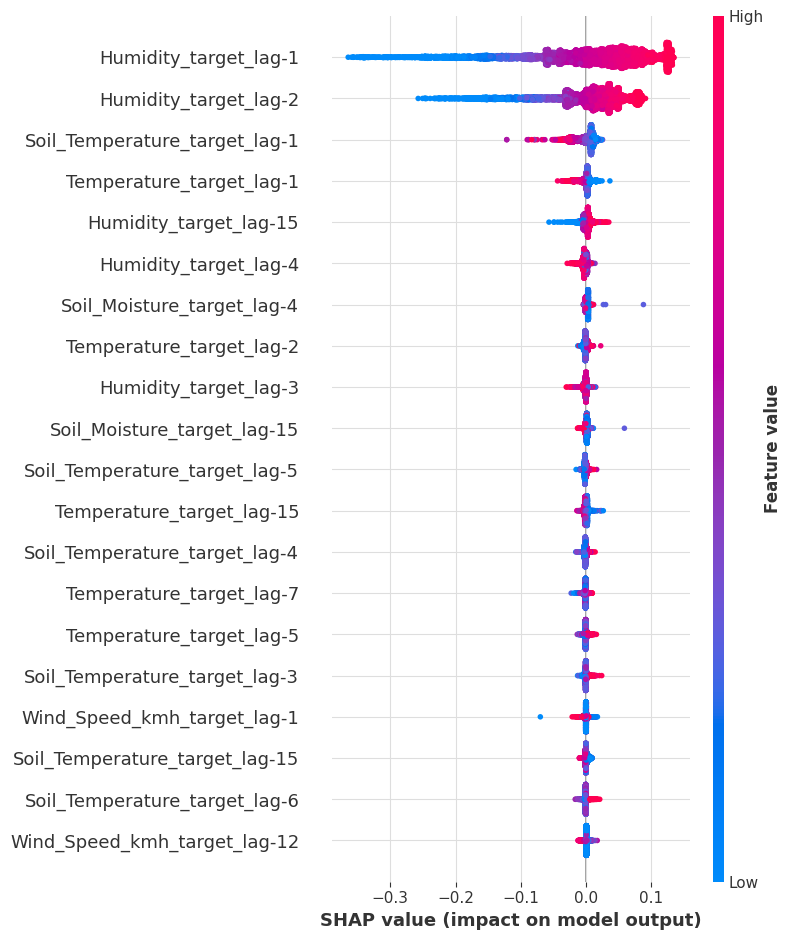

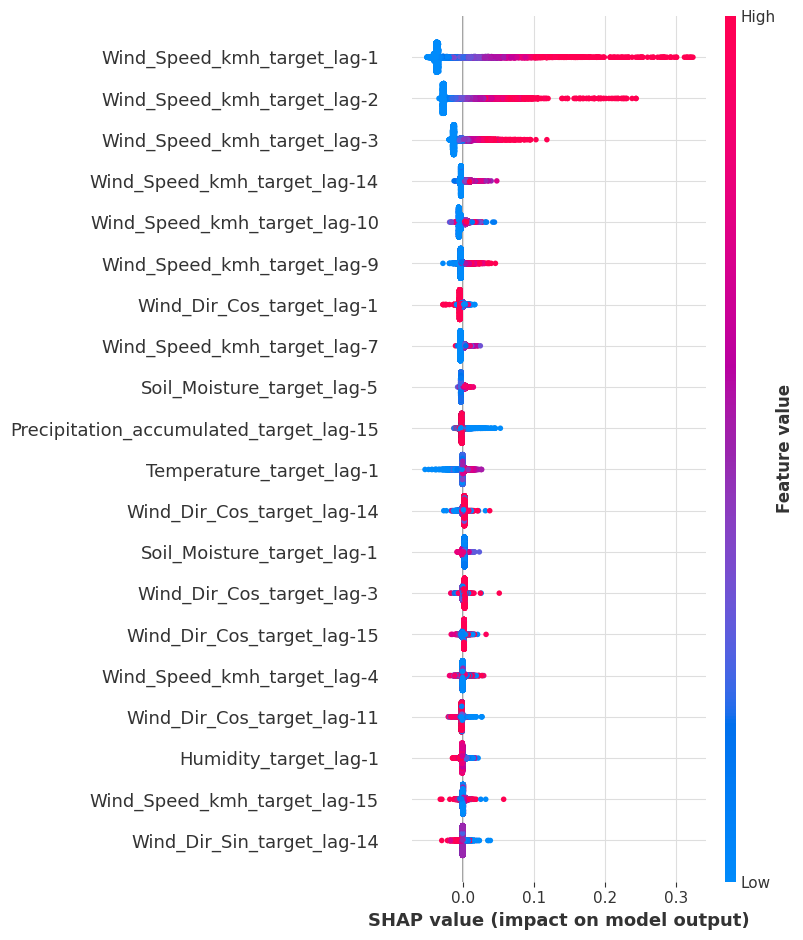

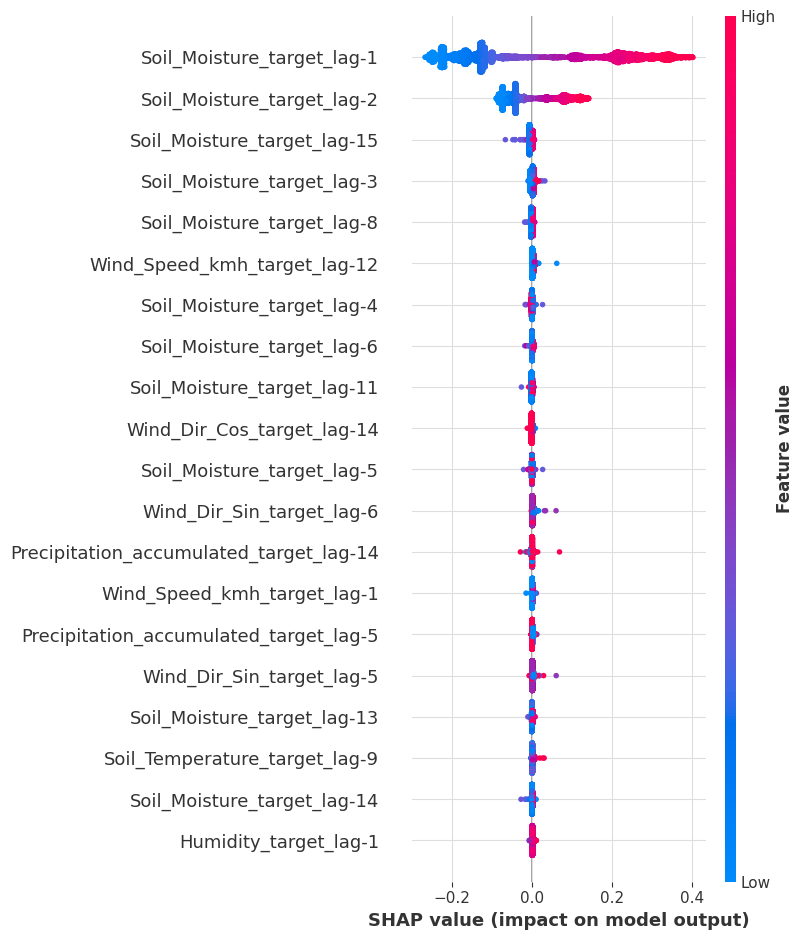

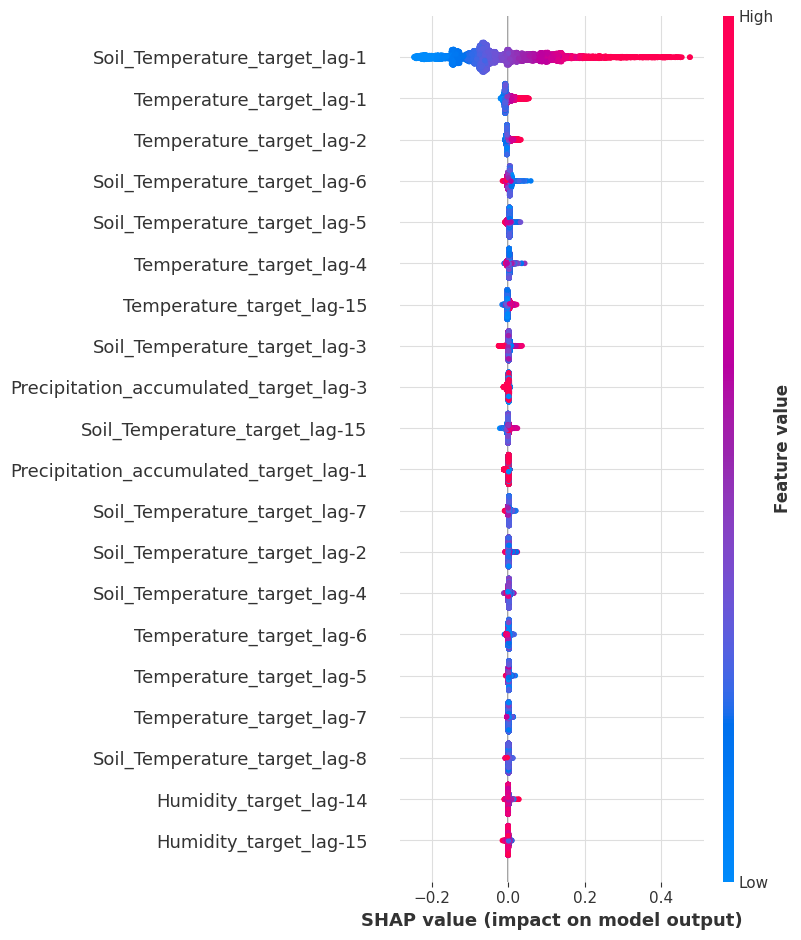

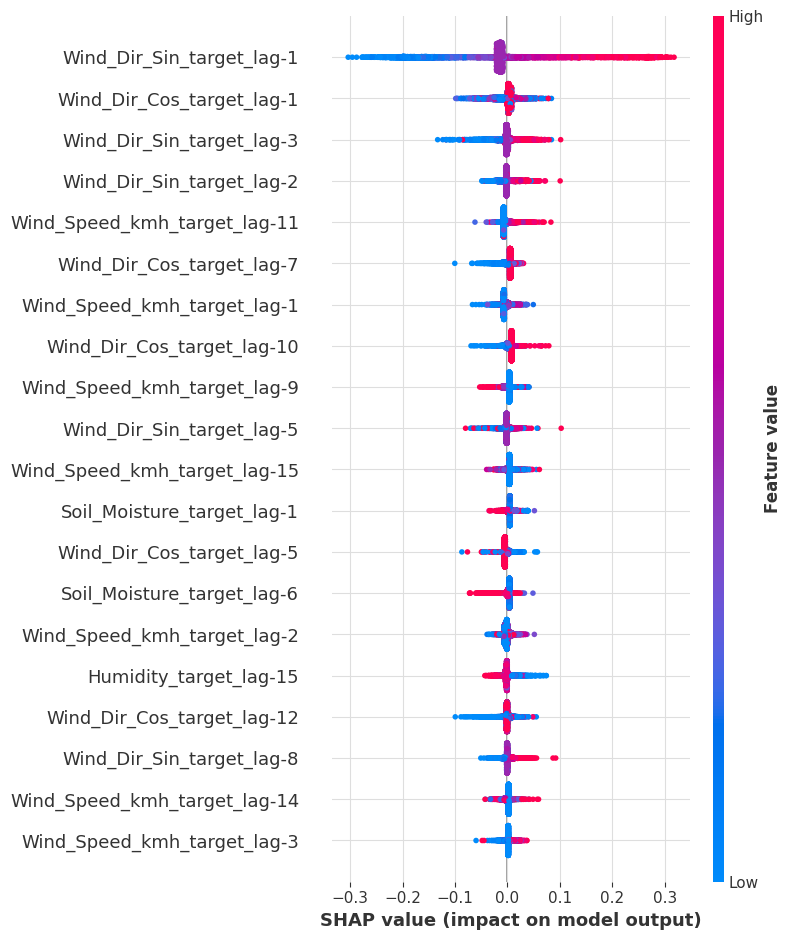

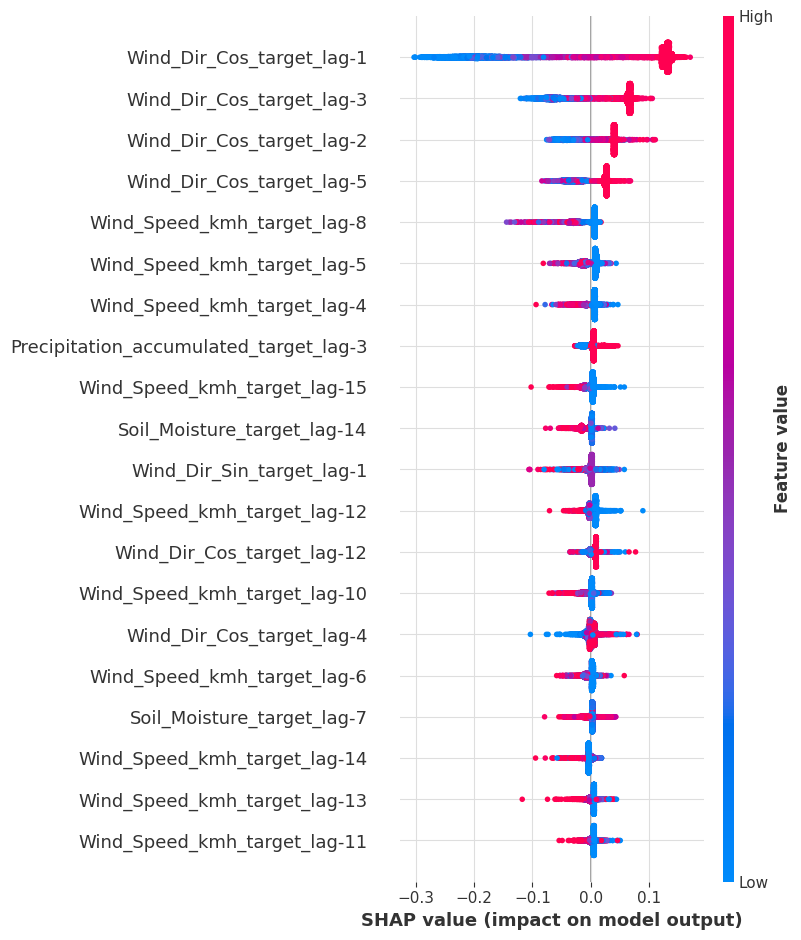

{1: {'Temperature': .values =
  array([[-2.0881637e-03,  3.4634043e-03, -1.8966356e-03, ...,
           3.1408053e-02,  3.0746954e-04, -4.7188406e-04],
         [-1.1134857e-03,  3.2823095e-03, -1.7974385e-04, ...,
          -1.2443583e-02,  7.4452208e-04, -1.5501374e-04],
         [-1.2122689e-04,  2.9705903e-03, -9.1198104e-04, ...,
          -2.6191574e-02,  3.5257344e-04,  2.9846653e-06],
         ...,
         [ 6.5229600e-04, -1.1368570e-02, -5.9531955e-04, ...,
          -8.0372728e-02, -7.5891888e-04,  9.2179871e-05],
         [ 7.0789026e-04, -1.1732419e-02, -1.3199578e-03, ...,
          -7.9474196e-02, -3.8514441e-04, -6.1523286e-04],
         [ 7.8584824e-04, -1.6204087e-02, -1.0933126e-03, ...,
          -7.5980693e-02, -2.2856685e-04, -5.2784162e-04]], dtype=float32)
  
  .base_values =
  array([0.35210702, 0.35210702, 0.35210702, ..., 0.35210702, 0.35210702,
         0.35210702], dtype=float32)
  
  .data =
  array([[0.12211088, 0.        , 0.92716866, ..., 0.30361879, 0

In [11]:
shap_explain.summary_plot()
# shap_explain.force_plot_from_ts()